In [1]:
import awkward as ak
import numba
import numpy as np
import pandas as pd
import awkward as ak
import vector
vector.register_numba()
vector.register_awkward()
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

from importlib import reload

import numba
import spanet_predictions

In [2]:
@numba.njit
def assign_provenance_and_prob(t1pred, t2pred, hpred, 
                      t1prob, t2prob, hprob, njets):
    out = np.zeros((t1pred.shape[0], njets)) -1
    prob = np.zeros((t1pred.shape[0], njets, 3), dtype=np.float32)-np.float32(np.inf)
    
    #print(prob)
    for iev, (t1, t2, h, t1p, t2p, hp) in enumerate(zip(t1pred, t2pred, hpred, t1prob, t2prob, hprob)):
    
        if t1[0] == -2:
            prob_t1 = -np.inf
        else:
            prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
            
        if t2[0] == -2:
            prob_t2 = -np.inf
        else:
            prob_t2 = t2p[t2[0]]
            
        if h[0] == -2:
            prob_h = -np.inf
        else:
            prob_h = hp[h[0]][h[1]]
            
        
        # prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
        # prob_t2 = t2p[t2[0]][t2[1]]
        # prob_h = hp[h[0]][h[1]]
        # print(prob_t1, prob_t2, prob_h)
        
        for i in t1: 
            out[iev][i] = 1
            prob[iev][i][0] = prob_t1
        for i in t2: 
            out[iev][i] = 2
            prob[iev][i][1] = prob_t2
        for i in h: 
            out[iev][i] = 3
            prob[iev][i][2] = prob_h

    return out, prob

In [3]:
basedir= "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_30_08_2023_v2/out_forTraining_sig_bkg"

In [4]:
os.listdir(basedir)

['all_jets_fullRun2_ttHTobb_forTraining_2018_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2017_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PostVFP_v3.parquet']

In [5]:
df = ak.from_parquet(basedir + "/all_jets_fullRun2_ttHTobb_forTraining_2018_v3.parquet")

In [6]:
df.fields

['jets',
 'partons_matched',
 'partons',
 'generator_info',
 'lepton_partons',
 'lepton_reco',
 'met',
 'higgs',
 'weight']

In [7]:
(jets,_,_,_,_,lep, met,_, weight) = ak.unzip(df)
jets = ak.with_name(jets, name="Momentum4D")
lep = ak.with_name(lep, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

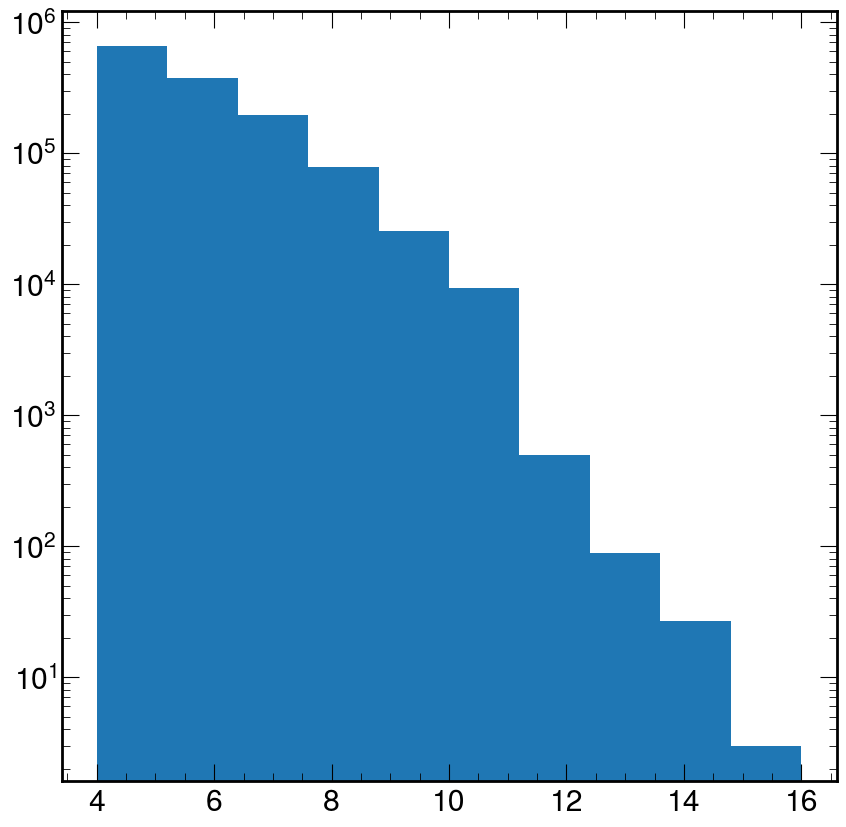

In [8]:
plt.hist(ak.num(jets))
plt.yscale("log")

In [11]:
!pip install onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.7 MB/s eta 0:00:0000:0100:01


In [8]:
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
sess_options = onnxruntime.SessionOptions()

sess_options.intra_op_num_threads = 10
sess_options.intra_op_num_threads = 10
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL


session = onnxruntime.InferenceSession(
    "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/SPANET/spanet.onnx", 
    sess_options = sess_options,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)

for input in session.get_inputs():
    print(f"{input.name}, {input.shape}")
    
for output in session.get_outputs():
    print(f"{output.name}, {output.shape}")

Source_data, ['batch_size', 'num_Source', 4]
Source_mask, ['batch_size', 'num_Source']
Met_data, ['batch_size', 'num_Met', 3]
Met_mask, ['batch_size', 'num_Met']
Lepton_data, ['batch_size', 'num_Lepton', 3]
Lepton_mask, ['batch_size', 'num_Lepton']
ht_data, ['batch_size', 'num_ht', 1]
ht_mask, ['batch_size', 'num_ht']
t1_assignment_log_probability, ['Reshapet1_assignment_log_probability_dim_0', 'Reshapet1_assignment_log_probability_dim_1', 'Reshapet1_assignment_log_probability_dim_2', 'Reshapet1_assignment_log_probability_dim_3']
t2_assignment_log_probability, ['Reshapet2_assignment_log_probability_dim_0', 'Reshapet2_assignment_log_probability_dim_1']
h_assignment_log_probability, ['Reshapeh_assignment_log_probability_dim_0', 'Reshapeh_assignment_log_probability_dim_1', 'Reshapeh_assignment_log_probability_dim_2']
t1_detection_log_probability, ['Logt1_detection_log_probability_dim_0']
t2_detection_log_probability, ['Logt1_detection_log_probability_dim_0']
h_detection_log_probability, [

2023-09-04 09:45:41.502173408 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [9]:
jets_padded = ak.fill_none(ak.pad_none(jets, 16, clip=True), {"btag":0., "pt":0., "phi":0., "eta":0.})

data = np.transpose(
    np.stack([
    ak.to_numpy(jets_padded.btag),
    ak.to_numpy(jets_padded.eta),
    ak.to_numpy(jets_padded.phi),
    np.log(1 + ak.to_numpy(jets_padded.pt))]),
    axes=[1,2,0]).astype(np.float32)

mask = ~ak.to_numpy(jets_padded.pt == 0)

met_data = np.stack([ak.to_numpy(met.eta),
                     ak.to_numpy(met.phi),
                     np.log(1+ ak.to_numpy(met.pt))], axis=1)[:,None,:].astype(np.float32)

lep_data = np.stack([ak.to_numpy(lep[:,0].eta),
                     ak.to_numpy(lep[:,0].phi),
                     np.log(1+ ak.to_numpy(lep[:,0].pt))], axis=1)[:,None,:].astype(np.float32)

ht_array = np.sum(ak.to_numpy(jets_padded.pt), axis=1)[:,None, None].astype(np.float32)

mask_global = np.ones(shape=[met_data.shape[0], 1]) == 1

In [12]:
batch_size = 10000
nbatches = data.shape[0]// batch_size
print(f"{nbatches=}")

nbatches=134


In [ ]:
from rich.progress import track

provenance = np.zeros((data.shape[0], 16))
prob_assignment = np.zeros((data.shape[0], 16, 3))


for i in range(5):
    print(i)
    offset = i*batch_size
    outputs = session.run(input_feed={
        "Source_data": data[offset: offset+batch_size],
        "Source_mask": mask[offset: offset+batch_size],
        "Met_data": met_data[offset: offset+batch_size],
        "Met_mask": mask_global[offset: offset+batch_size],
        "Lepton_data": lep_data[offset: offset+batch_size],
        "Lepton_mask": mask_global[offset: offset+batch_size],
        "ht_data": ht_array[offset: offset+batch_size], 
        "ht_mask": mask_global[offset: offset+batch_size]},
        output_names=["t1_assignment_log_probability", "t2_assignment_log_probability",
                     "h_assignment_log_probability"]
        )
    preds_nomask = spanet_predictions.extract_predictions(outputs[0:3], masking=False)
    prov, prob = assign_provenance_and_prob(*preds_nomask, outputs[0], outputs[1], outputs[2],16)
    
    provenance[offset:offset+batch_size] = prov
    prob_assignment[offset:offset+batch_size]= prob

0
1
2
3
4


In [76]:
import spanet_predictions

In [289]:
reload(spanet_predictions)

<module 'spanet_predictions' from '/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/SPANET/spanet_predictions.py'>

In [158]:
np.exp(np.max(outputs[2][0]))

0.31770414

In [161]:
outputs[0][2][3][4][2]

-15.7800665

In [168]:
outputs[0][2][2][3][4]

-11.3453

In [137]:
predictions = [out[0:1] for out in outputs[0:3]]

In [286]:
preds = spanet_predictions.extract_predictions(outputs[0:3])

In [290]:
preds_nomask = spanet_predictions.extract_predictions(outputs[0:3], masking=False)

In [291]:
preds_nomask

[array([[0, 1, 4],
        [2, 5, 1],
        [2, 5, 0],
        ...,
        [0, 4, 1],
        [0, 2, 3],
        [1, 5, 3]]),
 array([[3],
        [3],
        [4],
        [0],
        [2],
        [3],
        [2],
        [2],
        [1],
        [0],
        [1],
        [2],
        [5],
        [0],
        [1],
        [0],
        [2],
        [1],
        [1],
        [5],
        [4],
        [1],
        [3],
        [7],
        [1],
        [5],
        [3],
        [3],
        [2],
        [6],
        [0],
        [1],
        [2],
        [4],
        [0],
        [3],
        [1],
        [1],
        [1],
        [2],
        [3],
        [0],
        [0],
        [5],
        [1],
        [2],
        [1],
        [1],
        [4],
        [3],
        [3],
        [0],
        [1],
        [1],
        [4],
        [1],
        [2],
        [4],
        [0],
        [4],
        [2],
        [5],
        [3],
        [1],
        [3],
        [2],
        [4],


In [60]:
num_partons

array([1, 1, 1])

In [149]:
from math import exp

In [175]:
for i, (t1, t2, h,prob_t1, prob_t2, prob_h) in enumerate(zip(*preds,*outputs[-3:])):
    print(i, t1, t2, h, "njets:", np.sum(mask[i]), 
          f"prob t1: {exp(outputs[0][i][t1[0]][t1[1]][t1[2]]):.3f}",
         f"  prob t2: {exp(outputs[1][i][t2[0]]):.3f}"
         f"  prob H: {exp(outputs[2][i][h[0]][h[1]]):.3f}")

0 [-2 -2 -2] [3] [2 4] njets: 5 prob t1: 0.000   prob t2: 0.853  prob H: 0.318
1 [2 5 1] [3] [0 4] njets: 6 prob t1: 0.237   prob t2: 0.483  prob H: 0.000
2 [2 5 0] [4] [1 3] njets: 6 prob t1: 0.479   prob t2: 1.000  prob H: 0.493
3 [1 3 4] [0] [-2 -2] njets: 5 prob t1: 0.171   prob t2: 0.726  prob H: 0.000
4 [0 1 3] [5] [2 4] njets: 7 prob t1: 0.304   prob t2: 0.189  prob H: 0.303
5 [0 2 5] [3] [1 4] njets: 6 prob t1: 0.038   prob t2: 0.733  prob H: 0.293
6 [1 5 0] [2] [3 4] njets: 8 prob t1: 0.080   prob t2: 0.900  prob H: 0.404
7 [0 3 1] [2] [-2 -2] njets: 5 prob t1: 0.317   prob t2: 0.984  prob H: 0.000
8 [0 4 3] [1] [2 5] njets: 6 prob t1: 0.042   prob t2: 0.683  prob H: 0.214
9 [1 2 3] [0] [-2 -2] njets: 4 prob t1: 0.422   prob t2: 0.622  prob H: 0.000
10 [3 5 6] [1] [2 4] njets: 7 prob t1: 0.001   prob t2: 0.319  prob H: 0.189
11 [-2 -2 -2] [2] [0 3] njets: 4 prob t1: 0.000   prob t2: 0.351  prob H: 0.201
12 [3 4 1] [5] [0 2] njets: 6 prob t1: 0.164   prob t2: 0.490  prob H: 0.0

In [292]:
for i, (t1, t2, h,prob_t1, prob_t2, prob_h) in enumerate(zip(*preds_nomask,*outputs[-3:])):
    print(i, t1, t2, h, "njets:", np.sum(mask[i]), 
          f"prob t1: {exp(outputs[0][i][t1[0]][t1[1]][t1[2]]):.3f}",
         f"  prob t2: {exp(outputs[1][i][t2[0]]):.3f}"
         f"  prob H: {exp(outputs[2][i][h[0]][h[1]]):.3f}")

0 [0 1 4] [3] [2 4] njets: 5 prob t1: 0.234   prob t2: 0.853  prob H: 0.318
1 [2 5 1] [3] [3 4] njets: 6 prob t1: 0.237   prob t2: 0.483  prob H: 0.462
2 [2 5 0] [4] [1 3] njets: 6 prob t1: 0.479   prob t2: 1.000  prob H: 0.493
3 [1 3 4] [0] [2 4] njets: 5 prob t1: 0.171   prob t2: 0.726  prob H: 0.143
4 [0 1 3] [2] [2 4] njets: 7 prob t1: 0.304   prob t2: 0.297  prob H: 0.303
5 [2 3 4] [3] [1 4] njets: 6 prob t1: 0.120   prob t2: 0.733  prob H: 0.293
6 [1 7 2] [2] [3 4] njets: 8 prob t1: 0.081   prob t2: 0.900  prob H: 0.404
7 [0 3 1] [2] [2 4] njets: 5 prob t1: 0.317   prob t2: 0.984  prob H: 0.466
8 [2 4 3] [1] [2 5] njets: 6 prob t1: 0.184   prob t2: 0.683  prob H: 0.214
9 [1 2 3] [0] [0 3] njets: 4 prob t1: 0.422   prob t2: 0.622  prob H: 0.309
10 [3 5 1] [1] [2 4] njets: 7 prob t1: 0.116   prob t2: 0.319  prob H: 0.189
11 [0 1 2] [2] [2 3] njets: 4 prob t1: 0.245   prob t2: 0.351  prob H: 0.245
12 [3 4 1] [5] [2 5] njets: 6 prob t1: 0.164   prob t2: 0.490  prob H: 0.205
13 [1 5 4

In [47]:
ht_array.shape

(1344266, 1, 1)

In [183]:
prov = np.zeros((data.shape[0], 16))

In [192]:
import numba

In [280]:
prov, prob = assign_provenance_and_prob(*preds, outputs[0], outputs[1], outputs[2],16)

In [294]:
prov, prob = assign_provenance_and_prob(*preds_nomask, outputs[0], outputs[1], outputs[2],16)

In [298]:
np.exp(prob[100])

array([[0.        , 0.        , 0.22000757],
       [0.19950017, 0.        , 0.22000757],
       [0.19950017, 0.        , 0.        ],
       [0.19950017, 0.        , 0.        ],
       [0.        , 0.6669786 , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]], dtype=float32)

In [187]:
prov[preds[0]] = 2

In [189]:
prov[0]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])